In [39]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from jscon import astrometry
import importlib 
importlib.reload(astrometry)
from jscon import make_image as mk
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u

df = mk.get_catalog_info("../data/ibnorth.csv")
mask_hwmag = df["hwmag"] < 14.5
hwmag_targets = df["hwmag"] 
c = SkyCoord(df["ra"].values, df["dec"].values, frame="icrs", unit="deg")
gal_l = c.galactic.l.deg
gal_b = c.galactic.b.deg
ra = df["ra"].values * np.pi/180.0
dec = df["dec"].values * np.pi/180.0

crpix = [0,0]
arcsec_deg =  0.00027777777777778 ##
sigma_x = .8 # pixel for gaussian
sigma_y = .8 # pixel for gaussian
time_arr = np.linspace(2028, 2030, 7200)
time_ref = 2028

## convolved gaussian 
x_cen_arr = np.linspace(-100, 100, 20000)
y_val_arr = []

for x_cen in x_cen_arr:
    val = mk.pixel_1d_gaussian(x_cen, .5, sigma_x)
    y_val_arr.append(val)
gauss_conv = mk.interpolate.interp1d(x_cen_arr,  y_val_arr)

## make WCS & pixel values for targets
pix_arcsec = 0.4 #                   
cdelt =[pix_arcsec * arcsec_deg ,pix_arcsec * arcsec_deg]
skydir =  SkyCoord(359.85* u.deg , 0.54* u.deg, frame="galactic")#, l=0, b=0.5 * u.deg)
wcs = mk.create_wcs(skydir, "GAL", crpix = crpix, cdelt = cdelt)
pixel_targets = wcs.all_world2pix(gal_l, gal_b, 1)
image = mk.make_image(pixel_targets, hwmag_targets, gauss_conv)
pixel_targets = np.array(pixel_targets)


20532


Text(0, 0.5, 'b')

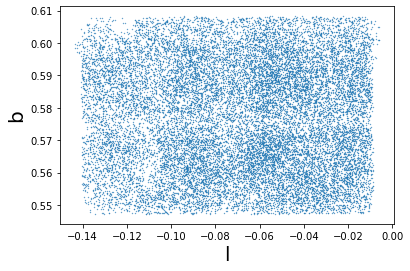

In [53]:
print(len(gal_l))
plt.scatter(gal_l-360, gal_b, s =0.1)
plt.xlabel("l", fontsize = 20)
plt.ylabel("b", fontsize = 20)

<ipython-input-51-8196e2be0510>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image), vmin = -3, vmax=2)


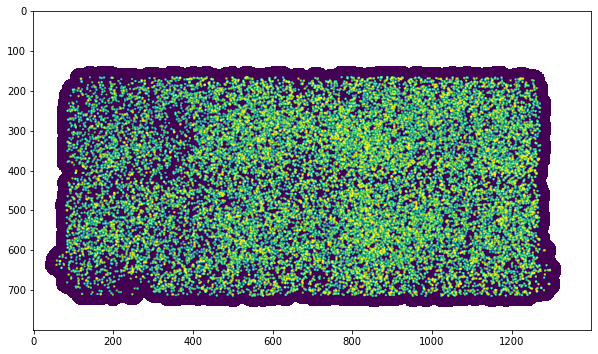

In [51]:
fig = plt.figure(figsize = (10, 8))
plt.imshow(np.log10(image), vmin = -3, vmax=2)

In [9]:
astro_info = np.load("../../result/out_prev/input_astro_info.npz")

def get_time(files):
    time_arr = []
    for file in files:
        time = float(file.replace("./out/displace_", "").replace(".npz", ""))
        time_arr.append(time)
    return time_arr

dx_arr = []
dy_arr = []

files = sorted(glob.glob("../../result/out_prev/displace*.npz" ))

for file in files:
    data = np.load(file)
    dx_arr.append(data["dx"])
    dy_arr.append(data["dy"])    
    
dx_arr = np.array(dx_arr)
dy_arr = np.array(dy_arr)


In [10]:
mask_targets = astro_info["mask_targets"]
ra = astro_info["ra"][mask_targets]
dec = astro_info["dec"][mask_targets]
pm_ra = astro_info["pm_ra"][mask_targets]
pm_dec = astro_info["pm_dec"][mask_targets]
distance = astro_info["distance"][mask_targets]
time= astro_info["time"]
time_ref = astro_info["time_ref"]
ra_delta, dec_delta= astrometry.compute_delta_ra_dec_all_phases(ra, dec, pm_ra, pm_dec, distance, time, time_ref)


/opt/anaconda3/envs/test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


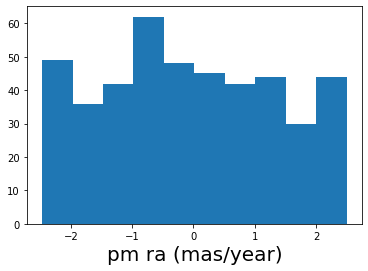

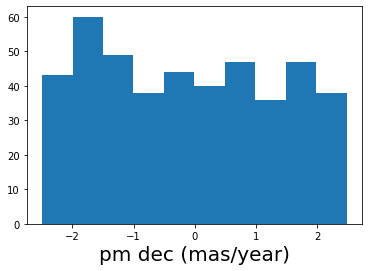

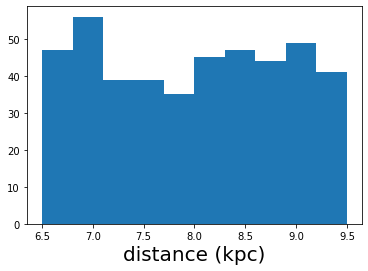

In [38]:
plt.hist(pm_ra)
plt.xlabel("pm ra (mas/year)", fontsize = 20)

plt.show()
plt.hist(pm_dec)
plt.xlabel("pm dec (mas/year)", fontsize = 20)
plt.show()
plt.hist(distance)
plt.xlabel("distance (kpc)", fontsize = 20)
plt.show()



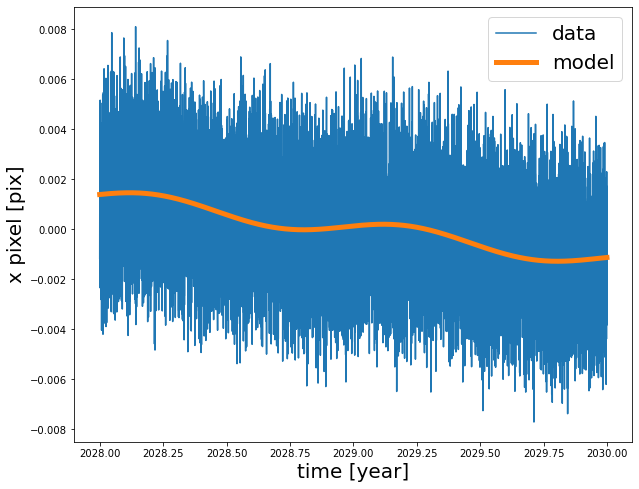

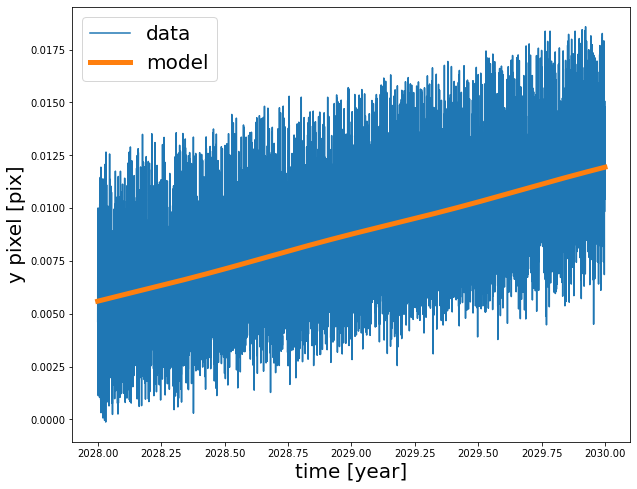

<ipython-input-31-c8c927b55e29>:28: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image), vmin = -1, vmax=2, extent=[lim_vals[0]-0.5, lim_vals[1]-0.5, lim_vals[3]-0.5, lim_vals[2]-0.5])


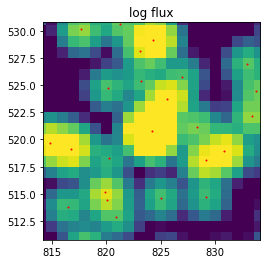

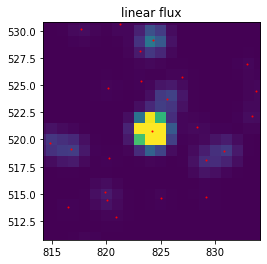

In [31]:
idx = 28

ra_delta_now = ra_delta[:,idx] * 0.001/0.4
dec_delta_now = dec_delta[:,idx] * 0.001/0.4
ra_shift_mean = np.mean( dx_arr[:,idx]-ra_delta_now )
dec_shift_mean = np.mean( dy_arr[:,idx]-dec_delta_now )

fig = plt.figure(figsize = (10,8))
plt.plot(time_arr, dx_arr[:,idx],  label="data")
plt.plot(time_arr, ra_shift_mean + ra_delta_now, label="model", lw = 5)
plt.xlabel("time [year]", fontsize = 20)
plt.ylabel("x pixel [pix]", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

fig = plt.figure(figsize = (10,8))
plt.plot(time_arr, dy_arr[:,idx],  label="data")
plt.plot(time_arr, dec_shift_mean +dec_delta_now, label="model", lw = 5)
plt.xlabel("time [year]", fontsize = 20)
plt.ylabel("y pixel [pix]", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

lim_vals = [0, 1400, -100, 700]
wd = 10
x_cen = pixel_targets[0][mask_targets][idx]
y_cen =  pixel_targets[1][mask_targets][idx]
plt.imshow(np.log10(image), vmin = -1, vmax=2, extent=[lim_vals[0]-0.5, lim_vals[1]-0.5, lim_vals[3]-0.5, lim_vals[2]-0.5])
plt.scatter(pixel_targets[0,:], pixel_targets[1, :], s = 1, color="r")
plt.xlim(x_cen -wd, x_cen +wd)
plt.ylim(y_cen -wd, y_cen +wd)
plt.title("log flux")
plt.show()
plt.imshow(image, vmax=1000, extent=[lim_vals[0]-0.5, lim_vals[1]-0.5, lim_vals[3]-0.5, lim_vals[2]-0.5])
plt.scatter(pixel_targets[0,:], pixel_targets[1, :], s = 1, color="r")
plt.xlim(x_cen -wd, x_cen +wd)
plt.ylim(y_cen -wd, y_cen +wd)
plt.title("linear flux")
plt.show()

<ipython-input-30-8be5749fc3c6>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image), vmin = -1, vmax=2, extent=[lim_vals[0]-0.5, lim_vals[1]-0.5, lim_vals[3]-0.5, lim_vals[2]-0.5])


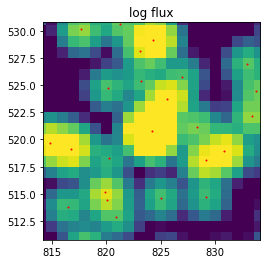

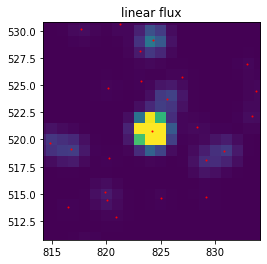

In [28]:
print(np.shape(image))

(800, 1400)
